In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [53]:
df_fpt= pd.read_csv('dataset/excel_fpt.csv')
columns = [i.replace('<', '').replace('>', '') for i in df_fpt.columns]
columns[1] = 'DateTime'
df_fpt.rename(columns = {df_fpt.columns[i]: columns[i] for i in range(len(df_fpt.columns))}, inplace = True)
df_fpt['DateTime'] = pd.to_datetime(df_fpt['DateTime'], format='%Y%m%d', errors='ignore')
df_fpt = df_fpt.set_index('DateTime')
df_fpt = df_fpt.sort_index()
df_fpt.head()

,Ticker,Open,High,Low,Close,Volume
DateTime,,,,,,
2006-12-13,FPT,22.5807,22.5807,22.5807,22.5807,83530
2006-12-14,FPT,23.7097,23.7097,23.7097,23.7097,280710
2006-12-15,FPT,24.8952,24.8952,24.8952,24.8952,265300
2006-12-18,FPT,26.1371,26.1371,26.1371,26.1372,215790
2006-12-19,FPT,27.4356,27.4356,27.4356,27.4356,137520


# CLOSE DIFF

In [ ]:
df = df_fpt.copy()
df['Close_diff_1'] = df['Close']-df.shift()['Close']
df['Close_diff_3'] = df['Close']-df.shift(2)['Close']
df['Close_diff_4'] = df['Close']-df.shift(3)['Close']
df['Close_diff_5'] = df['Close']-df.shift(4)['Close']
df['Close_diff_6'] = df['Close']-df.shift(5)['Close']
df['Close_diff_7'] = df['Close']-df.shift(6)['Close']

df.head()

In [ ]:
df = df[['Close_diff_1','Close_diff_3','Close_diff_4','Close_diff_5','Close_diff_6','Close_diff_7']]
df = df.dropna()
y_train = df[['Close_diff_1']]['2007-01-01':'2017-01-01'].to_numpy()
y_test = df[['Close_diff_1']]['2017-01-01':].to_numpy()
x_train = df[['Close_diff_3','Close_diff_4','Close_diff_5','Close_diff_6','Close_diff_7']]['2007-01-01':'2017-01-01'].to_numpy()
x_test = df[['Close_diff_3','Close_diff_4','Close_diff_5','Close_diff_6','Close_diff_7']]['2017-01-01':].to_numpy()
# print(x_train)

print("Train: {}\t Test: {}".format(len(x_train), len(x_test)))
print("Shape:", x_train.shape, y_train.shape)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
test_X = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print("Shape:", train_X.shape, y_train.shape)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


In [ ]:
model.summary()

In [ ]:
history = model.fit(train_X, y_train, epochs=50, batch_size=72, verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(y_test, yhat))
print('Test RMSE: %.3f' % rmse)

# Single LSTM 

In [346]:
df_fpt = df_fpt.sort_values('DateTime')
df_fpt.reset_index(inplace=True)
print(df_fpt.head())
close_prices = df_fpt.iloc[:, 4:5].values
print(close_prices.shape)

   index   DateTime Ticker     Open     High      Low    Close  Volume
0      0 2006-12-13    FPT  22.5807  22.5807  22.5807  22.5807   83530
1      1 2006-12-14    FPT  23.7097  23.7097  23.7097  23.7097  280710
2      2 2006-12-15    FPT  24.8952  24.8952  24.8952  24.8952  265300
3      3 2006-12-18    FPT  26.1371  26.1371  26.1371  26.1372  215790
4      4 2006-12-19    FPT  27.4356  27.4356  27.4356  27.4356  137520
(3490, 1)


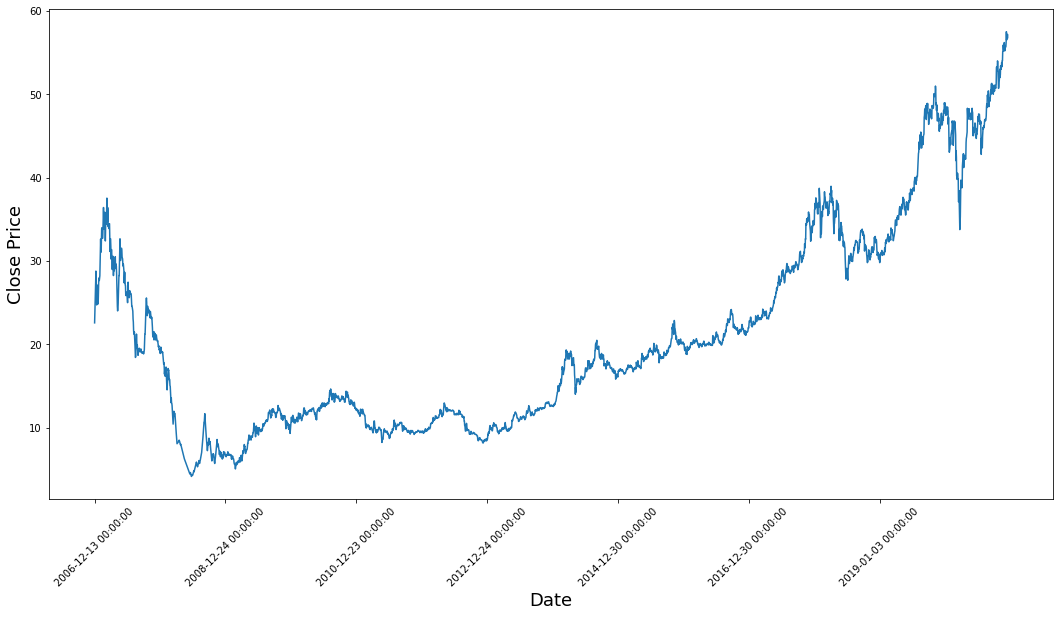

In [347]:
plt.figure(figsize = (18,9))
plt.plot(range(df_fpt.shape[0]),(df_fpt['Close']))
plt.xticks(range(0,df_fpt.shape[0],500),df_fpt['DateTime'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

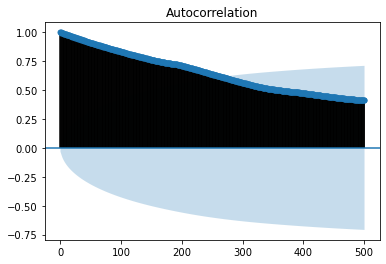

In [348]:
import statsmodels.api as sm
tmp = sm.graphics.tsa.plot_acf(df_fpt['Close'], lags=500)

In [349]:
X_train = []
y_train = []
timestamp = 20
for i in range(timestamp, len(close_prices)-500):
    X_train.append(close_prices[i-timestamp:i, 0])
    y_train.append(close_prices[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)
print(X_train, y_train)

(2970, 20) (2970,)
[[22.5807 23.7097 24.8952 ... 28.7904 27.9437 27.9437]
 [23.7097 24.8952 26.1371 ... 27.9437 27.9437 28.2259]
 [24.8952 26.1371 27.4356 ... 27.9437 28.2259 29.6372]
 ...
 [30.9702 31.3354 31.5545 ... 32.8693 32.504  32.5406]
 [31.3354 31.5545 31.7006 ... 32.504  32.5406 33.0518]
 [31.5545 31.7006 31.7006 ... 32.5406 33.0518 32.7232]] [28.2259 29.6372 31.1049 ... 33.0518 32.7232 32.2119]


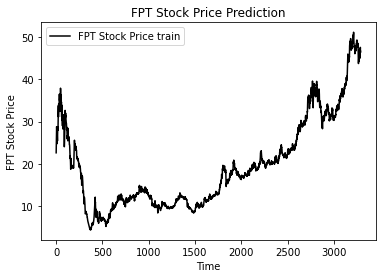

In [350]:
plt.plot(close_prices[:-200], color = 'black', label = 'FPT Stock Price train')
# plt.plot(predicted_stock_price, color = 'green', label = 'Predicted FPT Stock Price')
plt.title('FPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()


In [351]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
sc.fit(X_train)
x_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train.reshape(-1,1))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [146]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, epochs = 25, batch_size = 32)



Epoch 1/25
93/93 [==============================] - 7s 70ms/step - loss: 0.0159
Epoch 2/25
93/93 [==============================] - 6s 69ms/step - loss: 0.0034
Epoch 3/25
93/93 [==============================] - 6s 68ms/step - loss: 0.0029
Epoch 4/25
93/93 [==============================] - 6s 69ms/step - loss: 0.0027
Epoch 5/25
93/93 [==============================] - 7s 70ms/step - loss: 0.0028
Epoch 6/25
93/93 [==============================] - 6s 68ms/step - loss: 0.0026
Epoch 7/25
93/93 [==============================] - 6s 69ms/step - loss: 0.0026
Epoch 8/25
93/93 [==============================] - 6s 67ms/step - loss: 0.0023
Epoch 9/25
93/93 [==============================] - 6s 66ms/step - loss: 0.0022
Epoch 10/25
93/93 [==============================] - 6s 69ms/step - loss: 0.0021
Epoch 11/25
93/93 [==============================] - 6s 68ms/step - loss: 0.0021
Epoch 12/25
93/93 [==============================] - 6s 68ms/step - loss: 0.0019
Epoch 13/25
93/93 [==================

In [147]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [352]:
test = close_prices[len(close_prices)-500:].reshape(-1,1)
# print(len(test))
inputs = sc.fit_transform(test)
# print(np.array([inputs[i-7:i, 0]]).shape)
# X_test = np.array([inputs[:7, 0]]).reshape(1,7,1)
# print(X_test.shape)
# predicted_stock_price = []
# k = 1
# for i in range(7,100):
#     y_pred = model.predict(X_test)
#     predicted_stock_price.append(y_pred)
#     print("GT:",inputs[k:k+7])
#     X_test = np.concatenate((X_test[0,1:,0],y_pred[0])).reshape(1,7,1)
#     print("Pred:",X_test[0,:,0])
#     k += 1
# print(X_test.shape)
X_test = []
for i in range(timestamp, len(inputs)):
    X_test.append(inputs[i-timestamp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(480, 20, 1)


In [330]:
# print(len(predicted_stock_price))
# predicted_stock_price = np.array(predicted_stock_price).reshape(993,1)
# print(np.array(predicted_stock_price).shape)

In [150]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# predicted_stock_price = np.insert(predicted_stock_price, 0,0)
# print(test[:60].shape,predicted_stock_price.shape)
predicted_stock_price = np.concatenate((test[:timestamp],predicted_stock_price))
len(predicted_stock_price)
# print(predicted_stock_price)

500

500
500


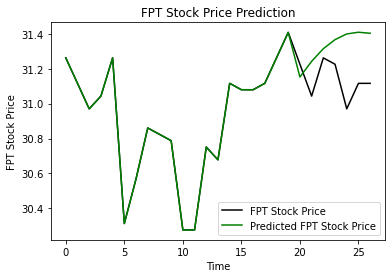

In [166]:
real_stock_price = test
print(len(predicted_stock_price))
print(len(real_stock_price))
plt.plot(real_stock_price[:27], color = 'black', label = 'FPT Stock Price')
plt.plot(predicted_stock_price[:27], color = 'green', label = 'Predicted FPT Stock Price')
plt.title('FPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()


In [168]:
# predict 7 ngay dau tien cua 30 ngay test
def MAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred) / y_true
#     error.replace([np.inf, -np.inf], np.nan, inplace=True)
    error = error[~np.isnan(error)]

    return np.mean(error) * 100
MAPE(real_stock_price[:27],predicted_stock_price[:27])

0.17580555912512466

# Multi Step Forecasting LSTM

In [251]:
df_fpt= pd.read_csv('dataset/excel_fpt.csv')
columns = [i.replace('<', '').replace('>', '') for i in df_fpt.columns]
columns[1] = 'DateTime'
df_fpt.rename(columns = {df_fpt.columns[i]: columns[i] for i in range(len(df_fpt.columns))}, inplace = True)
df_fpt['DateTime'] = pd.to_datetime(df_fpt['DateTime'], format='%Y%m%d', errors='ignore')
df_fpt = df_fpt.set_index('DateTime')
df_fpt = df_fpt.sort_index()
df_fpt.head()

,Ticker,Open,High,Low,Close,Volume
DateTime,,,,,,
2006-12-13,FPT,22.5807,22.5807,22.5807,22.5807,83530
2006-12-14,FPT,23.7097,23.7097,23.7097,23.7097,280710
2006-12-15,FPT,24.8952,24.8952,24.8952,24.8952,265300
2006-12-18,FPT,26.1371,26.1371,26.1371,26.1372,215790
2006-12-19,FPT,27.4356,27.4356,27.4356,27.4356,137520


In [252]:
df_fpt = df_fpt.sort_values('DateTime')
# df_fpt.reset_index(inplace=True)
close_prices = df_fpt.iloc[:, 4:5]
print(close_prices)

              Close
DateTime           
2006-12-13  22.5807
2006-12-14  23.7097
2006-12-15  24.8952
2006-12-18  26.1372
2006-12-19  27.4356
...             ...
2020-12-10  56.5000
2020-12-11  57.0000
2020-12-14  57.2000
2020-12-15  56.7000
2020-12-16  57.1000

[3490 rows x 1 columns]


In [253]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [254]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test


In [255]:
n_lag = 10
n_seq = 3
n_test = 200
train, test = prepare_data(close_prices, n_test, n_lag, n_seq)
print(train)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[22.5807 23.7097 24.8952 ... 27.0969 27.0969 25.9678]
 [23.7097 24.8952 26.1372 ... 27.0969 25.9678 24.8388]
 [24.8952 26.1372 27.4356 ... 25.9678 24.8388 25.4033]
 ...
 [45.5469 45.2961 46.8004 ... 46.0483 46.5497 46.7169]
 [45.2961 46.8004 46.5497 ... 46.5497 46.7169 46.3826]
 [46.8004 46.5497 46.6333 ... 46.7169 46.3826 45.6304]]
Train: (3278, 13), Test: (200, 13)


In [256]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

In [257]:
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [258]:
forecasts = make_forecasts(train, test, n_lag, n_seq)
print(forecasts)

[[46.7169, 46.7169, 46.7169], [46.3826, 46.3826, 46.3826], [45.6304, 45.6304, 45.6304], [45.129, 45.129, 45.129], [42.0368, 42.0368, 42.0368], [43.2068, 43.2068, 43.2068], [42.4547, 42.4547, 42.4547], [40.1982, 40.1982, 40.1982], [40.24, 40.24, 40.24], [39.7804, 39.7804, 39.7804], [40.5325, 40.5325, 40.5325], [40.4489, 40.4489, 40.4489], [39.8639, 39.8639, 39.8639], [39.8639, 39.8639, 39.8639], [37.1061, 37.1061, 37.1061], [37.1896, 37.1896, 37.1896], [38.4432, 38.4432, 38.4432], [36.9389, 36.9389, 36.9389], [36.0196, 36.0196, 36.0196], [33.7632, 33.7632, 33.7632], [34.3482, 34.3482, 34.3482], [35.351, 35.351, 35.351], [37.2732, 37.2732, 37.2732], [39.6968, 39.6968, 39.6968], [39.5297, 39.5297, 39.5297], [39.1536, 39.1536, 39.1536], [39.1536, 39.1536, 39.1536], [38.7775, 38.7775, 38.7775], [38.8611, 38.8611, 38.8611], [41.3682, 41.3682, 41.3682], [41.8697, 41.8697, 41.8697], [42.0368, 42.0368, 42.0368], [42.789, 42.789, 42.789], [42.8725, 42.8725, 42.8725], [41.2011, 41.2011, 41.2011],

In [259]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = np.sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [260]:
evaluate_forecasts(test, forecasts, n_lag, n_seq)


t+1 RMSE: 0.842976
t+2 RMSE: 1.163700
t+3 RMSE: 1.421155


In [261]:
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	plt.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		plt.plot(xaxis, yaxis, color='red')
	# show the plot
	plt.show()


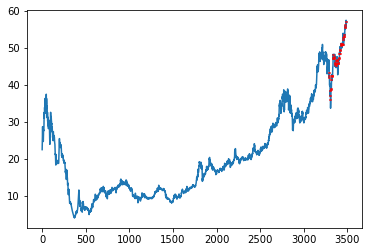

In [262]:
plot_forecasts(close_prices, forecasts, n_test+2)

In [263]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [264]:
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [265]:
scaler, train, test = prepare_data(close_prices, n_test, n_lag, n_seq)


In [266]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
		model.reset_states()
	return model

In [267]:
model = fit_lstm(train, n_lag, n_seq, 1, 150, 1)

3277/3277 [==============================] - 4s 1ms/step - loss: 0.0171


In [268]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [269]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [270]:
forecasts = make_forecasts(model, 1, train, test, n_lag, n_seq)
print(len(forecasts))

200


In [271]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [272]:
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [273]:
forecasts = inverse_transform(close_prices, forecasts, scaler, n_test+2)


In [274]:
actual = [row[n_lag:] for row in test]
actual = inverse_transform(close_prices, actual, scaler, n_test+2)

In [275]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = np.sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [311]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	plt.plot(np.concatenate((series.values[:len(series.values)-n_test],forecasts)))
	plt.plot(series.values)
	# plot the forecasts in red
# 	for i in range(len(forecasts)):
# 		off_s = len(series) - n_test + i - 1
# 		off_e = off_s + len(forecasts[i]) + 1
# 		xaxis = [x for x in range(off_s, off_e)]
# 		yaxis = [series.values[off_s]] + forecasts[i]
# 		plt.plot(xaxis, yaxis, color='red')
	# show the plot
	plt.show()


t+1 RMSE: 0.948123
t+2 RMSE: 1.231543
t+3 RMSE: 1.406022


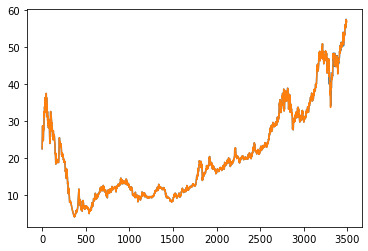

In [312]:
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(close_prices, np.asarray(forecasts)[:,2], n_test+2)


# Test class model

In [326]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

class lstm():
    """A class for an building and inferencing an lstm model"""
    
    def __init__(self, input_shape):
        self.model = Sequential()
        
        self.model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units = 50, return_sequences = True))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units = 50, return_sequences = True))
        self.model.add(Dropout(0.2))

        self.model.add(LSTM(units = 50))
        self.model.add(Dropout(0.2))

        self.model.add(Dense(units = 1))

        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    def load_model_weights(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model.load_weights(filepath)
    
    def predict(self,data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        print('[Model] Predicting...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted


In [353]:
model = lstm((x_train.shape[1], 1))

In [354]:
model.load_model_weights('model.h5')

[Model] Loading model from file model.h5


In [355]:
y_pred = model.predict(X_test).reshape(-1,1)

[Model] Predicting...


In [356]:
predicted_stock_price = sc.inverse_transform(y_pred)
# predicted_stock_price = np.insert(predicted_stock_price, 0,0)
# print(test[:60].shape,predicted_stock_price.shape)
predicted_stock_price = np.concatenate((test[:timestamp],predicted_stock_price))
len(predicted_stock_price)
# print(predicted_stock_price)

500

500
500


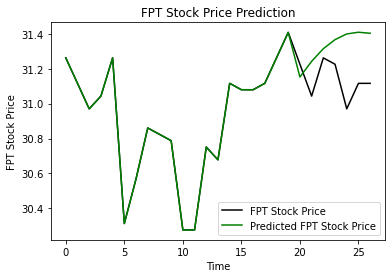

In [358]:
real_stock_price = test
print(len(predicted_stock_price))
print(len(real_stock_price))
plt.plot(real_stock_price[:27], color = 'black', label = 'FPT Stock Price')
plt.plot(predicted_stock_price[:27], color = 'green', label = 'Predicted FPT Stock Price')
plt.title('FPT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FPT Stock Price')
plt.legend()
plt.show()
